In [526]:
import numpy as np
import matplotlib.pyplot as plt
from DEBT_control_class import DEBT_Control_Protocol
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [527]:
np.random.seed(4)
n = 5
params = dict()
params["custom"] = True
params["custom_routes"] = True
C = np.zeros((n, n))
for i in range(n-1):
    C[i, i+1] = 100
    C[n-1, 0] = 100
C = C + C.T
params["capacity_matrix"] = C

In [528]:
def create_path(i, j):
    path = np.zeros((n, n))
    k = i
    while k != j:
        path[k, (k+1) % n] = 1
        k = (k+1) % n
    return path

paths = dict()
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        paths[(i, j)] = [create_path(i, j), create_path(j, i).T]
params["routes"] = paths

In [529]:
demand_params = dict()
demand_params["distribution"] = "deterministic"
demand_params["custom demands"] = True
mean = 10
sparsity = 0.4
demands = np.random.binomial(1, sparsity, (n, n))*np.random.poisson(mean, (n, n))
for i in range(n):
    demands[i,i] = 0
print("Demand Matrix:")
print(demands)
demand_params["demand_matrix"] = demands

Demand Matrix:
[[ 0  0  5 10 11]
 [ 0  0  0  0  0]
 [ 9  0  0  9  0]
 [ 0  0  0  0 15]
 [ 0 10 11 13  0]]


In [530]:
price_params = dict()
price_params["stepsize"] = 0.01
price_params["threshold"] = 5*np.ones((n,n))
price_params["sensitivity"] = 1*np.ones((n,n)) # regularizer coefficient

In [531]:
# initialize the PCN and the protocol
myPCN = DEBT_Control_Protocol(params, demand_params, price_params) 
# loop for T time steps
T = 1001

In [532]:
# create arrays to store flows and prices
flows_data = dict()
path_price_data = dict()
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] == 0:
            continue
        flows_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
        path_price_data[(i,j)] = np.zeros((T,len(myPCN.paths[(i,j)])))
edge_price_data = np.zeros((T, n, n))
reset_data = np.zeros((T, n, n))

In [533]:
logging.info("starting loop with %d iterations", T)
for t in range(T):
    logging.info("starting step %d", t)
    myPCN.single_step(t)
    edge_price_data[t] = myPCN.channel_prices.copy()
    for key in flows_data.keys():
        flows_data[key][t] = myPCN.flow_requests[key]
        path_price_data[key][t] = myPCN.path_prices[key]
        reset_data[t] = myPCN.channels_reset


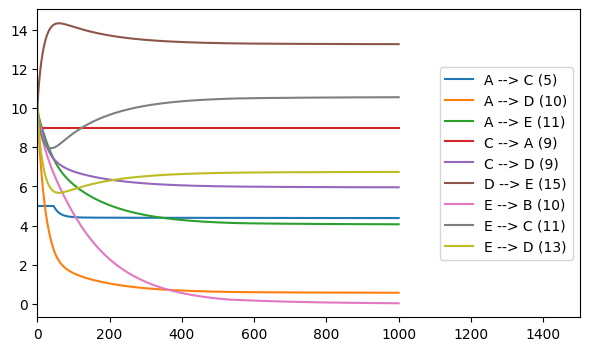

In [534]:
alphabets = ['A', 'B', 'C', 'D', 'E', 'F']
plt.close("all")
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            flow = np.zeros(T)
            for k in range(len(myPCN.paths[(i,j)])):
                flow += flows_data[(i,j)][:,k]
            plt.plot(flow, label = alphabets[i] + " --> " + alphabets[j] + " (" + str(myPCN.demands[i,j]) + ")")
plt.legend(loc='right')
plt.xlim([0, 1.5*T])
plt.savefig("flows_small_step.pdf")

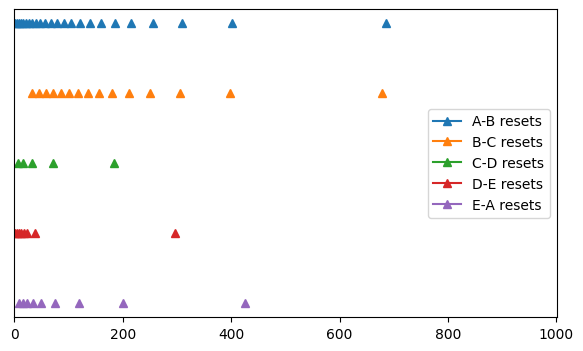

In [535]:
# replace all zeros with nan in reset_data
reset_data[reset_data == 0] = np.nan
reset_data
plt.figure(figsize=(7,4))
for i in range(n):
    plt.plot(reset_data[:,i, (i+1)%n]*(5-i), label = alphabets[i] + "-" + alphabets[(i+1)%n] + " resets", linestyle=None, marker='^')
    # remove ticks on y-axis
plt.yticks([])
plt.legend(loc='right')
plt.xlim([0, T])
plt.savefig("resets_small_step.pdf")

Text(0.5, 1.0, 'Prices as a function of time')

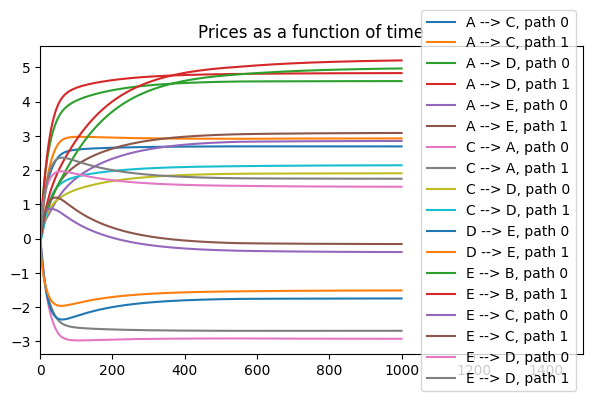

In [536]:
plt.figure(figsize=(7,4))
for i in range(n):
    for j in range(n):
        if myPCN.demands[i,j] > 0:
            for k in range(len(myPCN.paths[(i,j)])):
                plt.plot(path_price_data[(i,j)][:,k], label = alphabets[i] + " --> " + alphabets[j] + ", path " + str(k))
plt.legend(loc='right')
plt.xlim([0, 1.5*T])
plt.title("Prices as a function of time")